In [1]:
from image_functions import image_sampler, oklab_to_linear_srgb, linear_srgb_to_oklab
import skimage as ski
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from jax import vmap
import jax.random as jr
from IPython.display import HTML

matplotlib.rcParams["animation.embed_limit"] = 2**128
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False



In [2]:
# read in original image
im = mpimg.imread("bluecat.png")

# process image. downscaling is important, as it requires simulation of less particles
# im = im / 255 # uncomment if reading jpeg
im = ski.color.rgba2rgb(im) # uncomment if reading png
im = ski.transform.rescale(im, 0.25, channel_axis=-1, anti_aliasing=True, order=3)

In [3]:
# define and run sampler
manager = image_sampler(
    im,
    num_particles=50000,
    loss_space="oklab",
    posterization_params={"posterizer": "oklab", "n_colors": 12},
    smoother_params={"kernel_size": 1, "kernel_std": 1.,},
    likelihood_params={"INF":1e2, 'scaled':True},
    sampler_params={"lambd_range": (-1, 1.), "annealing_steps":50,'extra_steps':25},
)
out = manager.run(jr.key(4))

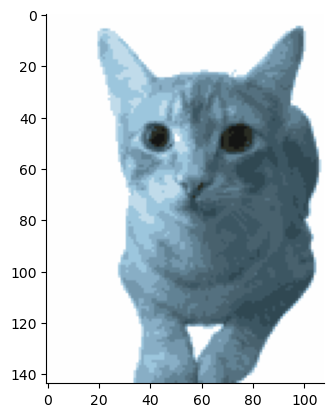

In [4]:
# view posterized image
plt.imshow(vmap(vmap(oklab_to_linear_srgb))(manager.palette))

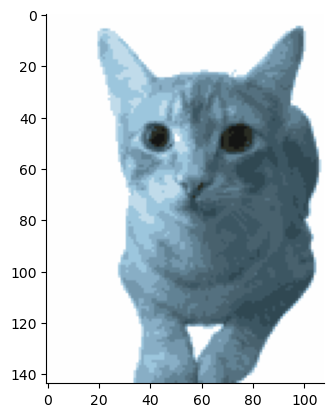

In [5]:
# potentially smoothed reference image. smoothing largely obsolete, not used here
plt.imshow(vmap(vmap(oklab_to_linear_srgb))(manager.ref_img))

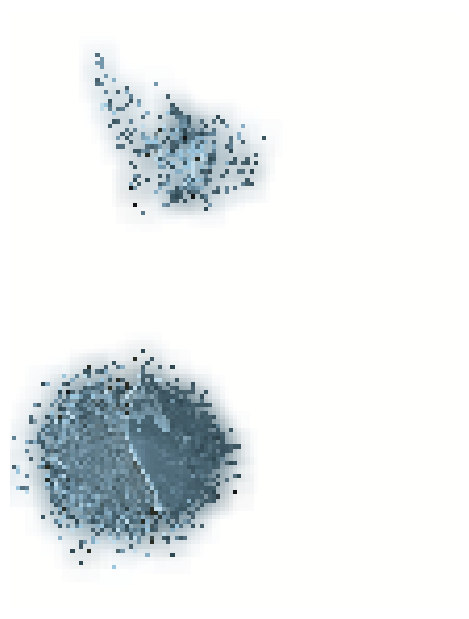

In [6]:
# render gif with white smoothing
ani = manager.draw_gif('cat_real.gif',render='img',start_frame=0, smoothing_params={'kernel_size':9, 'kernel_std':5.})
HTML(ani.to_jshtml())

means:
[ -2.9844592  10.9942     -3.109787   -3.4715822  -4.2278666  -3.7904346
  -3.4606779  -3.395917  -38.539303   -3.510076   -4.569609   -3.709977 ]
stds:
[0.8581279  1.9645063  0.6886495  0.8320267  0.8474343  0.95000154
 0.85953236 0.8759938  1.202086   0.93242633 1.0222661  0.05536173]

mins:
[ -3.7822127   5.232727   -3.7644682  -4.2702565  -5.034731   -6.4107227
  -6.330157   -6.2927947 -49.17642    -6.2495384  -8.441047   -4.095923 ]
maxs:
[  0.17970264  12.6287      -1.4389504   -1.8423824   -2.5213509
  -1.7840347   -1.6345763   -1.7118905  -37.40577     -1.5414395
  -2.5174208   -3.6569552 ]


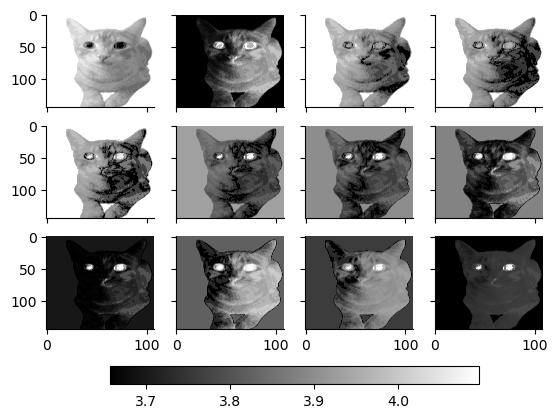

In [7]:
# show loss for each particle color. as this plots negative loglikelihood, particles seek
# regions with low (dark) values.
manager.show_loss_map()